In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Input, Conv2D, MaxPooling2D,GlobalMaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Activation, MaxPool2D, AvgPool2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications import DenseNet121, VGG19, ResNet50
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from IPython.display import display, Image
import matplotlib.pyplot as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import warnings
warnings.filterwarnings("ignore")

from sklearn.utils import shuffle
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
#读数据
train_df = pd.read_csv('C:/Users/JxmDe/Desktop/Project_E/562468_1022626_bundle_archive/Chest_xray_Corona_Metadata.csv')
valid_df = pd.read_csv('C:/Users/JxmDe/Desktop/Project_E/562468_1022626_bundle_archive/Chest_xray_Corona_dataset_Summary.csv')

print('The training dataset has rows : ', format(train_df.shape[0]))
print('The training dataset has cols : ', format(train_df.shape[1]))

The training dataset has rows :  5910
The training dataset has cols :  6


In [4]:
train_df.head(5)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [5]:
train_df.isnull().sum()

Unnamed: 0                   0
X_ray_image_name             0
Label                        0
Dataset_type                 0
Label_2_Virus_category    5841
Label_1_Virus_category    1576
dtype: int64

In [6]:
train_data = train_df[train_df['Dataset_type'] == 'TRAIN']
test_data = train_df[train_df['Dataset_type'] == 'TEST']

assert train_data.shape[0] + test_data.shape[0] == train_df.shape[0] #确保训练集和测试集行数相加等于总数据集行数

print(f"Shape of train data : {train_data.shape}")
print(f"Shape of test data : {test_data.shape}")

test_data.sample(10)

Shape of train data : (5286, 6)
Shape of test data : (624, 6)


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5766,5789,person80_bacteria_392.jpeg,Pnemonia,TEST,NaN,bacteria
5646,5669,person122_bacteria_583.jpeg,Pnemonia,TEST,NaN,bacteria
5867,5890,person1680_virus_2897.jpeg,Pnemonia,TEST,NaN,Virus
5580,5603,person143_bacteria_688.jpeg,Pnemonia,TEST,NaN,bacteria
5399,5422,NORMAL2-IM-0307-0001.jpeg,Normal,TEST,NaN,NaN
5388,5411,NORMAL2-IM-0322-0001.jpeg,Normal,TEST,NaN,NaN
5517,5540,NORMAL2-IM-0339-0001.jpeg,Normal,TEST,NaN,NaN
5858,5881,person173_bacteria_831.jpeg,Pnemonia,TEST,NaN,bacteria
5396,5419,NORMAL2-IM-0311-0001.jpeg,Normal,TEST,NaN,NaN
5870,5893,person1676_virus_2892.jpeg,Pnemonia,TEST,NaN,Virus


In [9]:
#用unknown填充缺失值
train_fill = train_data.fillna('unknown')
test_fill = test_data.fillna('unknown')

display(train_fill.head(5))

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,unknown,unknown
1,1,IM-0127-0001.jpeg,Normal,TRAIN,unknown,unknown
2,2,IM-0125-0001.jpeg,Normal,TRAIN,unknown,unknown
3,3,IM-0122-0001.jpeg,Normal,TRAIN,unknown,unknown
4,4,IM-0119-0001.jpeg,Normal,TRAIN,unknown,unknown


In [10]:
#开辟读取路径
train_img_dir = 'C:/Users/JxmDe/Desktop/Project_E/562468_1022626_bundle_archive/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
test_img_dir = 'C:/Users/JxmDe/Desktop/Project_E/562468_1022626_bundle_archive/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'

#确保以上路径为文件目录
assert os.path.isdir(test_img_dir) == True
assert os.path.isdir(train_img_dir) == True

sample_train_images = list(os.walk(train_img_dir))[0][2][:8] #获取该路径文件下前8个图像的文件名
sample_train_images = list(map(lambda x: os.path.join(train_img_dir, x), sample_train_images)) #把目录和文件名合并

sample_test_images = list(os.walk(test_img_dir))[0][2][:8]
sample_test_images = list(map(lambda x: os.path.join(test_img_dir, x), sample_test_images))

In [38]:
# list(os.walk(train_img_dir))[0][2][:8]

['01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg',
 '1-s2.0-S0140673620303706-fx1_lrg.jpg',
 '1-s2.0-S0929664620300449-gr2_lrg-a.jpg',
 '1-s2.0-S0929664620300449-gr2_lrg-b.jpg',
 '1-s2.0-S0929664620300449-gr2_lrg-c.jpg',
 '1-s2.0-S0929664620300449-gr2_lrg-d.jpg',
 '1-s2.0-S0929664620300449-gr3_lrg-a.jpg',
 '1-s2.0-S0929664620300449-gr3_lrg-b.jpg']

In [44]:
# sample_train_images

['C:/Users/JxmDe/Desktop/Project_E/562468_1022626_bundle_archive/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train\\01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg',
 'C:/Users/JxmDe/Desktop/Project_E/562468_1022626_bundle_archive/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train\\1-s2.0-S0140673620303706-fx1_lrg.jpg',
 'C:/Users/JxmDe/Desktop/Project_E/562468_1022626_bundle_archive/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train\\1-s2.0-S0929664620300449-gr2_lrg-a.jpg',
 'C:/Users/JxmDe/Desktop/Project_E/562468_1022626_bundle_archive/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train\\1-s2.0-S0929664620300449-gr2_lrg-b.jpg',
 'C:/Users/JxmDe/Desktop/Project_E/562468_1022626_bundle_archive/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train\\1-s2.0-S0929664620300449-gr2_lrg-c.jpg',
 'C:/Users/JxmDe/Desktop/Project_E/562468_1022626_bundle_archive/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train\\1-

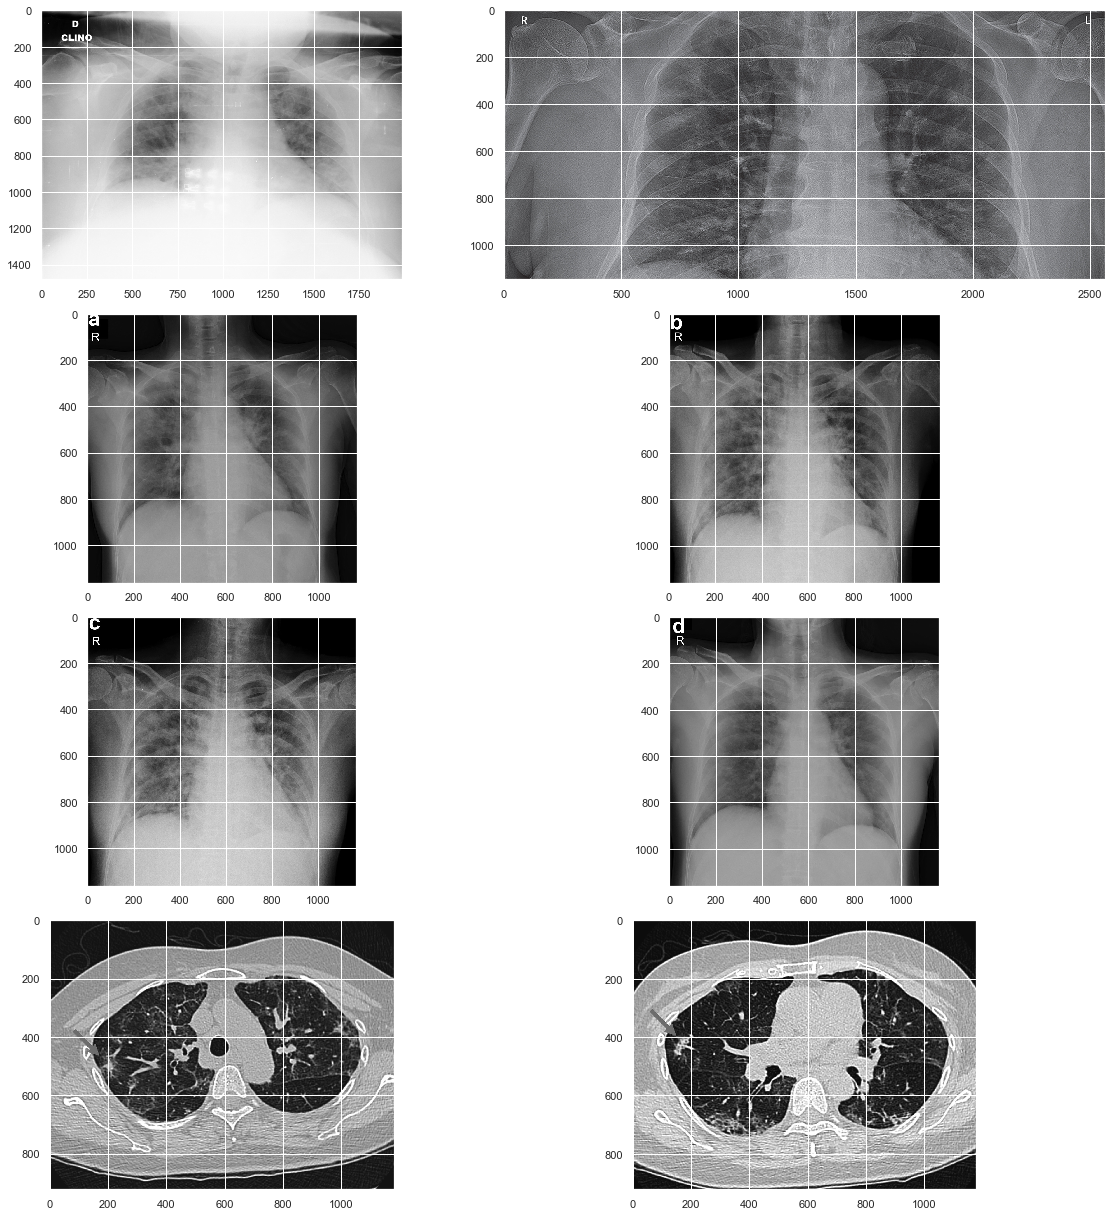

In [40]:
from PIL import Image

plt.figure(figsize = (17,17))
for iterator, filename in enumerate(sample_train_images):
    image = Image.open(filename)
    plt.subplot(4,2,iterator+1)
    plt.imshow(image)

plt.tight_layout() # 无卵用，只是自动调整子图参数，使之填充整个图像区域

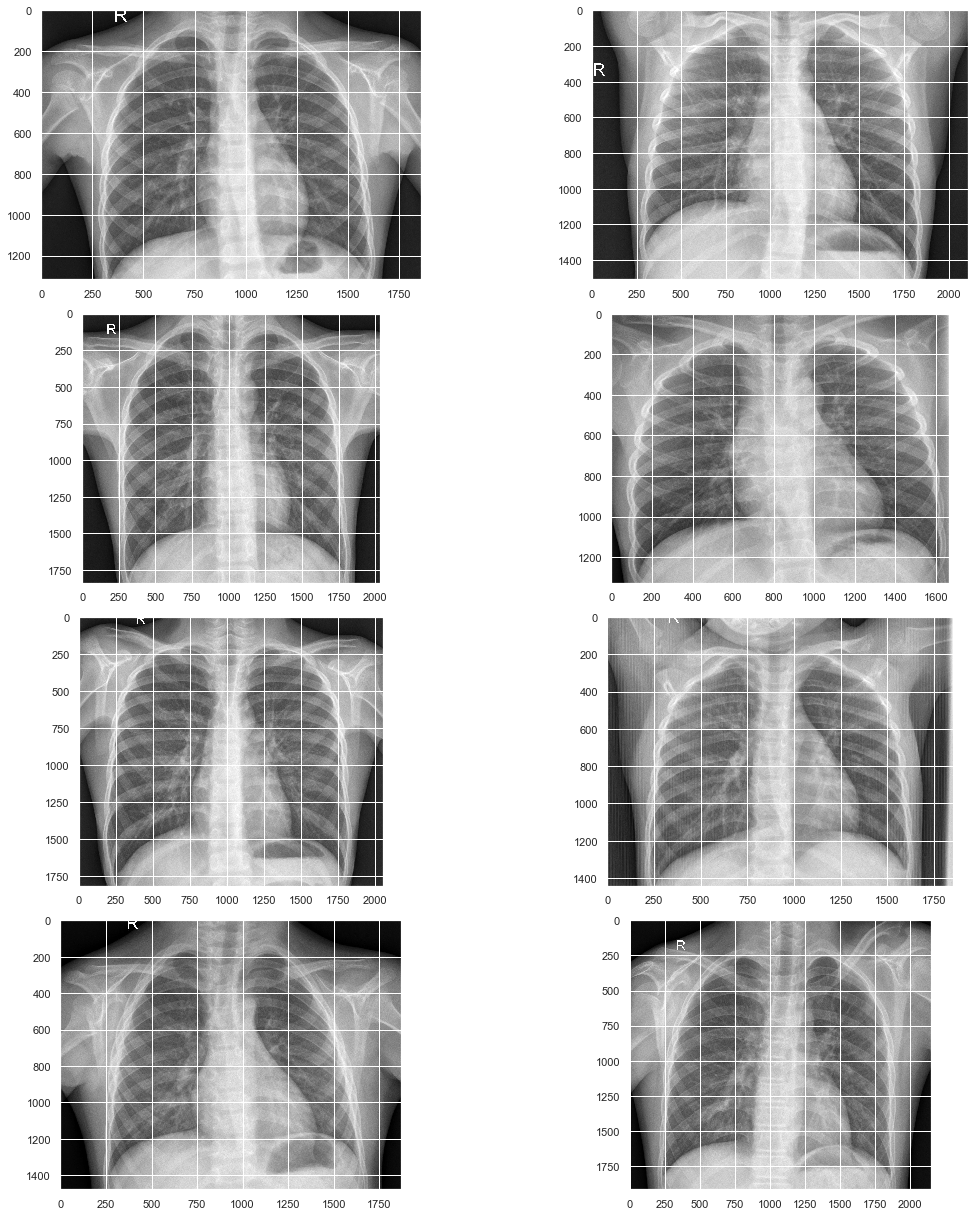

In [42]:
plt.figure(figsize = (17,17))
for iterator, filename in enumerate(sample_test_images):
    image = Image.open(filename)
    plt.subplot(4,2,iterator+1)
    plt.imshow(image, cmap=plt.cm.gray) # 这里如果不设置颜色，显示出来就是红色的

plt.tight_layout()

In [55]:
# 创建最终使用的训练集：Normal的和患COVID-19的，共1400
final_data = train_data[(train_data['Label'] == 'Normal') | 
                              ((train_data['Label'] == 'Pnemonia') & (train_data['Label_2_Virus_category'] == 'COVID-19'))]

# 给数据集添一列，名叫‘target’，也就是我们常说的label，分negative和positive两种
final_data['target'] = ['negative' if holder == 'Normal' else 'positive' for holder in final_data['Label']]

final_data = shuffle(final_data, random_state=1)

final_train_data = final_data.iloc[:1000, :] # 1000条
final_validation_data = final_data.iloc[1000:, :] # 400条

print(f"Final train data shape : {final_train_data.shape}")

final_train_data.sample(10)

Final train data shape : (1000, 7)


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,target
1209,1209,NORMAL2-IM-1176-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
181,181,IM-0327-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
1201,1201,NORMAL2-IM-1184-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
1106,1106,NORMAL2-IM-1058-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
835,835,NORMAL2-IM-0793-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
5225,5234,jkms-35-e79-g001-l-c.jpg,Pnemonia,TRAIN,COVID-19,Virus,positive
997,997,NORMAL2-IM-0971-0001-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
1012,1012,NORMAL2-IM-0951-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
46,46,IM-0230-0001.jpeg,Normal,TRAIN,NaN,NaN,negative
1079,1079,NORMAL2-IM-1104-0001.jpeg,Normal,TRAIN,NaN,NaN,negative


In [56]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=0.5,
)

test_image_generator = ImageDataGenerator(
    rescale=1./255
)

# 训练集
train_generator = train_image_generator.flow_from_dataframe(
    dataframe=final_train_data,
    directory=train_img_dir,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=16,
    seed=2020,
    shuffle=True,
    class_mode='binary'
)

# 验证集
validation_generator = train_image_generator.flow_from_dataframe(
    dataframe=final_validation_data,
    directory=train_img_dir,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=16,
    seed=2020,
    shuffle=True,
    class_mode='binary'
)

# 测试集
test_generator = test_image_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=test_img_dir,
    x_col='X_ray_image_name',
    target_size=(224, 224),
    shuffle=False,
    batch_size=16,
    class_mode=None)

Found 1000 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 624 validated image filenames.


In [57]:
IMG_W = 224
IMG_H = 224
CHANNELS = 3

INPUT_SHAPE = (IMG_W, IMG_H, CHANNELS)
NB_CLASSES = 2
EPOCHS = 30
BATCH_SIZE = 6

In [58]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(Conv2D(250,(3,3)))
model.add(Activation("relu"))

  
model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))
model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))

model.add(Conv2D(256,(2,2)))
model.add(Activation("relu"))
model.add(MaxPool2D(2,2))
    
model.add(Flatten())
model.add(Dense(32))
model.add(Dropout(0.25))
model.add(Dense(1))
model.add(Activation("sigmoid"))

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        1

In [60]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch = 150,
                   validation_data=validation_generator,
                   epochs=15,
                             validation_steps=30)

Epoch 1/15
150/150 [==============================] - 270s 2s/step - loss: 0.5481 - accuracy: 0.9579 - val_loss: 0.8034 - val_accuracy: 0.9479
Epoch 2/15
150/150 [==============================] - 268s 2s/step - loss: 0.5592 - accuracy: 0.9635 - val_loss: 0.7712 - val_accuracy: 0.9500
Epoch 3/15
150/150 [==============================] - 263s 2s/step - loss: 0.5206 - accuracy: 0.9664 - val_loss: 0.8355 - val_accuracy: 0.9458
Epoch 4/15
150/150 [==============================] - 276s 2s/step - loss: 0.5013 - accuracy: 0.9672 - val_loss: 0.8034 - val_accuracy: 0.9479
Epoch 5/15
150/150 [==============================] - 264s 2s/step - loss: 0.5784 - accuracy: 0.9627 - val_loss: 0.8998 - val_accuracy: 0.9417
Epoch 6/15
150/150 [==============================] - 261s 2s/step - loss: 0.5206 - accuracy: 0.9660 - val_loss: 0.8998 - val_accuracy: 0.9417
Epoch 7/15
150/150 [==============================] - 263s 2s/step - loss: 0.5591 - accuracy: 0.9639 - val_loss: 0.8355 - val_accuracy: 0.9458

In [68]:
test_data['target'] = ['negative' if holder == 'Normal' else 'positive' for holder in test_data['Label']]

test_data['target']

5286    negative
5287    negative
5288    negative
5289    negative
5290    negative
          ...   
5905    positive
5906    positive
5907    positive
5908    positive
5909    positive
Name: target, Length: 624, dtype: object

In [ ]:
test_scores = model.evaluate(test_generator, test_data['target']) # 这里报错了，不知道怎么解决，好像是因为图像数据不能用evaluate来快速查看
print("\n%s: %.4f%%" % (model.metrics_names[1], test_scores[1]*100))

如果想查看预测性能，应该用model.predict实现。
但是在kaggle上看到原作者用CNN在validation集上进行预测，把所有样本都预测成了negative阴性，就感觉再进行预测毫无意义。